In [1]:
import sys
import time
import torch
from torch.utils.data import TensorDataset
import numpy as np
from matplotlib import pyplot as plt
import logging

sys.path.append("../../")
import manifold_flow as mf
from manifold_flow import transforms, utils, flows, distributions, training, timer
from manifold_flow import nn as nn_

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Timing function

In [2]:
def make_data(dim, n=100):
    return torch.randn(dim*n).view(n, dim)

In [3]:
def make_model(xdim, blocks=5, ldim=1):
    trf = flows.vector_transforms.create_transform(
        dim=xdim,
        flow_steps=5,
        linear_transform_type="permutation",
        base_transform_type="affine-coupling",
        hidden_features=20,
        num_transform_blocks=blocks,
        dropout_probability=0.,
        use_batch_norm=False
    )
    return trf

In [4]:
def time_logdet(model, data, repeats=3):
    times = []
    for _ in range(repeats):
        time_before = time.time()
        
        _ = model(data, full_jacobian=False)
        
        time_after = time.time()
        
        print(time_after-time_before, "s")
        times.append(time_after-time_before)
    return np.mean(times), np.std(times)

In [5]:
def time_jacobian(model, data, repeats=3):
    times = []
    for _ in range(repeats):
        # timer.reset()
        time_before = time.time()
        
        _ = model(data, full_jacobian=True)
        
        time_after = time.time()
        # timer.report()
        
        print(time_after-time_before, "s")
        times.append(time_after-time_before)
    return np.mean(times), np.std(times)

In [6]:
def run(xdim, blocks=5, jacobian=True):
    data = make_data(xdim)
    data.requires_grad = True
    model = make_model(xdim, blocks)
    if jacobian:
        return time_jacobian(model, data)
    else:
        return time_logdet(model, data)

## Go!

In [8]:
blocks = [1,2,5,10]
xdims = [2,5,10,20,50,100]

jacobian_means = []
jacobian_stds = []
det_means = []
det_stds = []

for block in blocks:
    for xdim in xdims:
        print("blocks = {}, xdim = {}".format(block, xdim))
        mean_jac, std_jac = run(xdim, block, True)
        mean_det, std_det = run(xdim, block, False)
        jacobian_means.append(mean_jac)
        jacobian_stds.append(std_jac)
        det_means.append(mean_det)
        det_stds.append(std_det)

blocks = np.asarray(blocks)
xdims = np.asarray(xdims)
jacobian_means = np.asarray(jacobian_means).reshape(len(blocks), -1)
jacobian_stds = np.asarray(jacobian_stds).reshape(len(blocks), -1)
det_means = np.asarray(det_means).reshape(len(blocks), -1)
det_stds = np.asarray(det_stds).reshape(len(blocks), -1)


blocks = 1, xdim = 2
0.2684903144836426 s
0.255450963973999 s
0.3442208766937256 s
0.002090930938720703 s
0.003125905990600586 s
0.001950979232788086 s
blocks = 1, xdim = 5
0.6998522281646729 s
0.6864221096038818 s
0.7573750019073486 s
0.0019021034240722656 s
0.0021200180053710938 s
0.0020749568939208984 s
blocks = 1, xdim = 10
1.3244481086730957 s
1.3085589408874512 s
1.3915369510650635 s
0.0020308494567871094 s
0.002248048782348633 s
0.0022268295288085938 s
blocks = 1, xdim = 20
3.013721227645874 s
2.788015127182007 s
2.8440330028533936 s
0.0025930404663085938 s
0.0023589134216308594 s
0.002410888671875 s
blocks = 1, xdim = 50
8.103314876556396 s
8.443613767623901 s
8.185001850128174 s
0.0036368370056152344 s
0.0035598278045654297 s
0.003242969512939453 s
blocks = 1, xdim = 100
19.350239276885986 s
19.027868032455444 s
19.145887851715088 s
0.004991292953491211 s
0.0043489933013916016 s
0.004312992095947266 s
blocks = 2, xdim = 2
0.32641100883483887 s
0.35906481742858887 s
0.344464063

## Plot

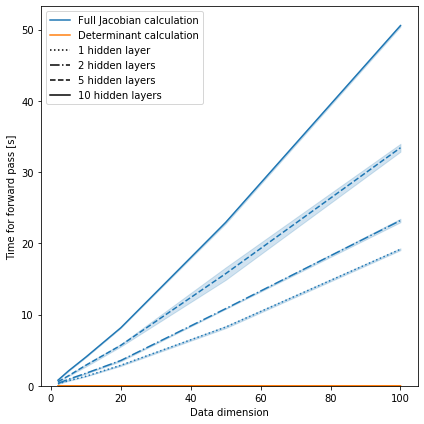

In [16]:
linestyles = [":", "-.", "--", "-"]
fig = plt.figure(figsize=(6,6))

for i, (block, ls) in enumerate(zip(blocks, linestyles)):
    plt.fill_between(xdims, jacobian_means[i] - jacobian_stds[i], jacobian_means[i]+jacobian_stds[i], color="C0", alpha=0.2)
    plt.plot(xdims, jacobian_means[i], c="C0", ls=ls)
    
    plt.fill_between(xdims, det_means[i] - det_stds[i], det_means[i]+det_stds[i], color="C1", alpha=0.2)
    plt.plot(xdims, det_means[i], c="C1", ls=ls)
    
plt.plot([], [], c="C0", ls="-", label="Full Jacobian calculation")
plt.plot([], [], c="C1", ls="-", label="Determinant calculation")
plt.plot([], [], c="black", ls=":", label="1 hidden layer")
plt.plot([], [], c="black", ls="-.", label="2 hidden layers")
plt.plot([], [], c="black", ls="--", label="5 hidden layers")
plt.plot([], [], c="black", ls="-", label="10 hidden layers")
plt.legend()

plt.xlabel("Data dimension")
plt.ylabel("Time for forward pass [s]")
# plt.ylim(1.e-3,1.e2)
# plt.yscale("log")

plt.ylim(0.,None)

plt.tight_layout()
plt.savefig("manifold_flow_timing.pdf")
